## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дату мягкого и жесткого дедлайна см. на стр. в `notion`
### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

/home/maxim/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
df = pd.read_csv('YearPredictionMSD.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [5]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [6]:
set_random_seed(42)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Обучение модели Ridge регрессии
model = Ridge()  
model.fit(X_train_scaled, y_train)

# Прогнозирование и оценка модели
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE for Ridge Regression:", rmse)



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


RMSE for Ridge Regression: 9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [7]:
# Качество наилучшего константного прогноза
best_constant = y_train.mean()
y_pred_constant = np.full_like(y_test, best_constant)
best_rmse_metric = np.sqrt(mean_squared_error(y_test, y_pred_constant))
print("RMSE for Best Constant Prediction:", best_rmse_metric)

RMSE for Best Constant Prediction: 10.863228020678134


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [23]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

In [33]:
model = LinearRegressionModel(X_train_scaled.shape[1])

learning_rate = 0.00001
num_epochs = 10
losses_train = []
losses_test = []
metric_train = []
metric_test = []

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

for epoch in range(num_epochs):
    predictions = model(X_train_tensor)

    # Расчет потерь (RMSE)
    loss = torch.mean((predictions - y_train_tensor.view(-1, 1))**2)
    loss = torch.sqrt(loss)
    losses_train.append(loss.item())
    metric_train.append(loss.item())    

    # Обратное распространение: вычисляем градиент функции потерь по параметрам модели
    loss.backward()

    # Обновление весов модели
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
        
    model.zero_grad()

    # Проверка на тестовых данных
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = torch.mean((test_predictions - y_test_tensor.view(-1, 1))**2)
        losses_test.append(test_loss.item())
        metric = torch.sqrt(test_loss)
        metric_test.append(metric.item())

    print(f'Эпоха {epoch+1}/{num_epochs}, Тренировочные потери: {loss.item():.4f}, Тестовые потери: {test_loss.item():.4f}, Метрика: {metric.item():.4f}')


Эпоха 1/10, Тренировочные потери: 1816.3881, Тестовые потери: 2813791.2500, Метрика: 1677.4359
Эпоха 2/10, Тренировочные потери: 1681.5728, Тестовые потери: 2403407.5000, Метрика: 1550.2927
Эпоха 3/10, Тренировочные потери: 1556.1346, Тестовые потери: 2057179.5000, Метрика: 1434.2871
Эпоха 4/10, Тренировочные потери: 1441.6089, Тестовые потери: 1771477.8750, Метрика: 1330.9688
Эпоха 5/10, Тренировочные потери: 1339.4924, Тестовые потери: 1541625.2500, Метрика: 1241.6221
Эпоха 6/10, Тренировочные потери: 1251.0233, Тестовые потери: 1361832.0000, Метрика: 1166.9756
Эпоха 7/10, Тренировочные потери: 1176.9032, Тестовые потери: 1225317.3750, Метрика: 1106.9406
Эпоха 8/10, Тренировочные потери: 1117.0486, Тестовые потери: 1124671.7500, Метрика: 1060.5054
Эпоха 9/10, Тренировочные потери: 1070.4910, Тестовые потери: 1052424.5000, Метрика: 1025.8774
Эпоха 10/10, Тренировочные потери: 1035.5107, Тестовые потери: 1001655.6875, Метрика: 1000.8275


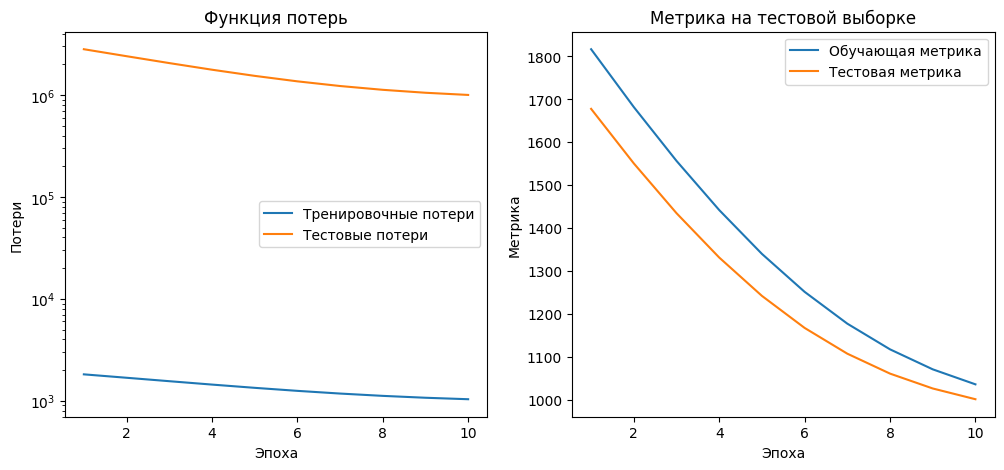

In [34]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), losses_train, label='Тренировочные потери')
plt.plot(range(1, num_epochs+1), losses_test, label='Тестовые потери')
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.yscale('log')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), metric_train, label='Обучающая метрика')
plt.plot(range(1, num_epochs+1), metric_test, label='Тестовая метрика')
plt.title('Метрика на тестовой выборке')
plt.xlabel('Эпоха')
plt.ylabel('Метрика')
plt.legend()

plt.show()

Метрики успешно изменяются в соответсвии с ожиданиями

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [7]:
import torch.utils.data as data

In [10]:
train_data = data.TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_data = data.TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

batch_size = 64
train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=batch_size)

class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(X_train.shape[1])

## Первый эксперимент

In [16]:
def train(model, optimizer, criterion, train_loader, test_loader, epochs=10):
    train_losses = []
    test_losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}')

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                test_loss += loss.item()
        test_losses.append(test_loss / len(test_loader))

        print(f'Test Loss: {test_losses[-1]:.4f}')

    return train_losses, test_losses

def test(model, criterion, test_loader):
    model.eval()
    predicts = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs)
            predicts.append(outputs)

    predicts = torch.cat(predicts).view(-1)
    print(predicts)
    return predicts

In [ ]:
# Функция потерь (RMSE)
def rmse_loss(outputs, targets):
    return torch.sqrt(torch.mean((outputs - targets)**2))

CRITERION = rmse_loss

In [17]:
assert test(model, CRITERION, test_loader).shape[0] == y_test.shape[0]

In [18]:
# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
train_losses, test_losses = train(model, optimizer, CRITERION, train_loader, test_loader, epochs=10)

# Тестирование модели
predicts = test(model, CRITERION, test_loader)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Эпоха 1/10, Тренировочные потери: 9.6246, Тестовые потери: 8.6320
Эпоха 2/10, Тренировочные потери: 9.5821, Тестовые потери: 8.9815
Эпоха 3/10, Тренировочные потери: 9.5711, Тестовые потери: 9.2950
Эпоха 4/10, Тренировочные потери: 9.5707, Тестовые потери: 8.9859
Эпоха 5/10, Тренировочные потери: 9.5631, Тестовые потери: 8.6595
Эпоха 6/10, Тренировочные потери: 9.5471, Тестовые потери: 9.1063
Эпоха 7/10, Тренировочные потери: 9.5349, Тестовые потери: 9.0386
Эпоха 8/10, Тренировочные потери: 9.5086, Тестовые потери: 8.7064
Эпоха 9/10, Тренировочные потери: 9.5227, Тестовые потери: 8.9639
Эпоха 10/10, Тренировочные потери: 9.4991, Тестовые потери: 9.1068


## Второй эксперимент

In [19]:
model = NeuralNet(X_train.shape[1])

# Оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Обучение модели
train_losses, test_losses = train(model, optimizer, CRITERION, train_loader, test_loader, epochs=10)

# Тестирование модели
predicts = test(model, CRITERION, test_loader)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Эпоха 1/10, Тренировочные потери: 147.6087, Тестовые потери: 40.9091
Эпоха 2/10, Тренировочные потери: 35.5939, Тестовые потери: 36.5668
Эпоха 3/10, Тренировочные потери: 35.8793, Тестовые потери: 46.2707
Эпоха 4/10, Тренировочные потери: 35.9930, Тестовые потери: 35.7943
Эпоха 5/10, Тренировочные потери: 35.9968, Тестовые потери: 33.7122
Эпоха 6/10, Тренировочные потери: 35.7204, Тестовые потери: 34.8865
Эпоха 7/10, Тренировочные потери: 35.8416, Тестовые потери: 45.7208
Эпоха 8/10, Тренировочные потери: 35.7152, Тестовые потери: 28.2284
Эпоха 9/10, Тренировочные потери: 35.3533, Тестовые потери: 29.0156
Эпоха 10/10, Тренировочные потери: 35.6982, Тестовые потери: 55.0883


## Третий эксперимент

In [ ]:
model = NeuralNet(X_train.shape[1])

# Оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Обучение модели
train_losses, test_losses = train(model, optimizer, CRITERION, train_loader, test_loader, epochs=10)

# Тестирование модели
predicts = test(model, CRITERION, test_loader)

## Четвёртый эксперимент

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, dropout_rate=0.5):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [ ]:
model = NeuralNet(input_size=X_train.shape[1], dropout_rate=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Обучение модели
train_losses, test_losses = train(model, optimizer, CRITERION, train_loader, test_loader, epochs=10)

# Тестирование модели
predicts = test(model, CRITERION, test_loader)

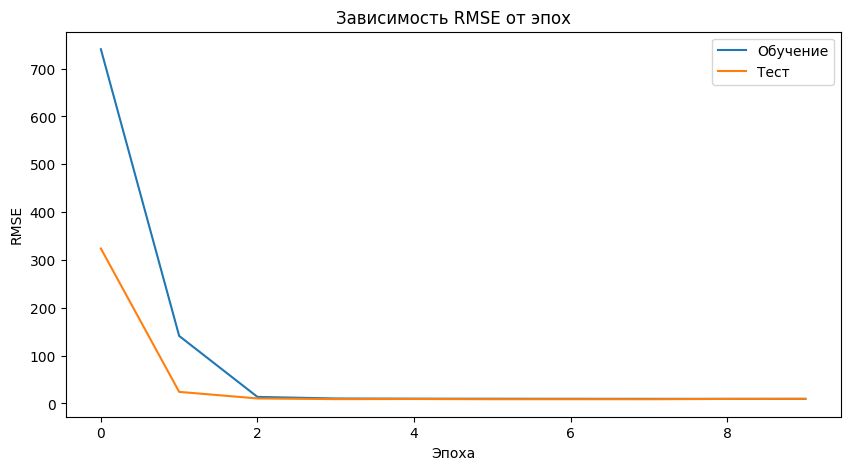

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Обучение')
plt.plot(test_losses, label='Тест')
plt.title('Зависимость RMSE от эпох')
plt.xlabel('Эпоха')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

### Отчет

Из-за уже полученных максимальных баллов за почти все иные работы, данная работа делалась с гораздо меньшим приоритетом. Посему мы не проводили работу с данными, а сделали лишь небольшое число экспериментов с обучениями.
Первое обучение проводилось на оптимизаторе Adam с lr=0.001. Оно уже дало достаточную точность равную 8.6595. Если сохранять лучшую модель, то первого экперимента было бы достаточно для 10 баллов.
Второй и третий эксперименты были провердены уже с SDG с разным lr, но не дали хорошего результата.
ЛУчший результат был на 4 эксперименте, с добавлением dropout и weight_decay b cjcnfdbk 8.6318.

Далее можно ещё эксперементировать с данными, планировщиками и гиперпараметрами, но всявязи с уже достаточной точностю, это не имеет смысла.

### Сумма ваших баллов: 

20/20